In [4]:
# !pip install names-dataset

In [1]:
import torch
from names_dataset import NameDataset
import re
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

In [2]:
SEED = 42

# Data

In [3]:
nd = NameDataset()

In [4]:
country_codes = ["US", "CA", "GB", "IN"]            # USA, Canada, Great Britain, India

In [5]:
dataset = set()
dataset_size = 50000
for code in country_codes:
    data = nd.get_top_names(n=dataset_size, country_alpha2=code)
    dataset.update(set(data[code]['M'] + data[code]['F']))

In [6]:
len(dataset)

43231

In [7]:
# clean and make each name 1 word
names = list()
for name in dataset:
    if re.match(r"^[A-Za-z\s]+$", name):            # only consider names with english alphabets
        for i in name.split():
            if len(i)>1: names.append(i.lower())

# Basic Count model

simple way is to generate next char based on prob of occuring with prev char

## Dataset stats

In [9]:
len(names)

43877

In [11]:
names[:10]

['arwen',
 'digpal',
 'niya',
 'mathieu',
 'aravindan',
 'westley',
 'endless',
 'loryn',
 'fateha',
 'robenson']

In [12]:
# min and max length words
min(len(name) for name in names), max(len(name) for name in names)

(2, 16)

In [13]:
# create bigrams
for name in names[:2]:
    for c1,c2 in zip(name, name[1:]): #zip([1,2,3],[2,3]) -> [(1,2), (2,3)]. terminates if either of list is empty
        print(c1, c2)

a r
r w
w e
e n
d i
i g
g p
p a
a l


In [14]:
# create bigrams with start and end
for name in names[:2]:
    name = ['<S>']+list(name)+['<E>']
    for c1,c2 in zip(name, name[1:]): #zip([1,2,3],[2,3]) -> [(1,2), (2,3)]. terminates if either of list is empty
        print(c1, c2)

<S> a
a r
r w
w e
e n
n <E>
<S> d
d i
i g
g p
p a
a l
l <E>


In [15]:
# create bigrams with simple '.' -> reduces special character by 1, space efficiency
for name in names[:2]:
    name = ['.']+list(name)+['.']
    for c1,c2 in zip(name, name[1:]): #zip([1,2,3],[2,3]) -> [(1,2), (2,3)]. terminates if either of list is empty
        print(c1, c2)

. a
a r
r w
w e
e n
n .
. d
d i
i g
g p
p a
a l
l .


## modelling

In [16]:
# an intuitive way to think about this is -> predict the next character based on the probabilities of bigrams in training set
# create a counts of all the possible bigrams in the training set
def count_bigrams(names:list):
    counts = {}
    for name in names:
        name = ['.'] + list(name) + ['.']
        for c1,c2 in zip(name, name[1:]):
            bigram = (c1,c2)
            counts[bigram] = counts.get(bigram,0) + 1     # get the current count(0 if None) and increment
    return counts
    

In [17]:
count_bigrams(names[:2])            # test for first 2 names

{('.', 'a'): 1,
 ('a', 'r'): 1,
 ('r', 'w'): 1,
 ('w', 'e'): 1,
 ('e', 'n'): 1,
 ('n', '.'): 1,
 ('.', 'd'): 1,
 ('d', 'i'): 1,
 ('i', 'g'): 1,
 ('g', 'p'): 1,
 ('p', 'a'): 1,
 ('a', 'l'): 1,
 ('l', '.'): 1}

In [18]:
# for the whole dataset
counts = count_bigrams(names) 

In [19]:
sorted(counts.items(), key=lambda item: item[1])[:10]     # sort based on the 2nd element(count) of items

[(('m', 'w'), 1),
 (('p', 'v'), 1),
 (('h', 'q'), 1),
 (('q', 'l'), 1),
 (('j', 'f'), 1),
 (('b', 'f'), 1),
 (('p', 'g'), 1),
 (('f', 'q'), 1),
 (('t', 'q'), 1),
 (('c', 'b'), 1)]

In [20]:
sorted(counts.items(), key=lambda item: -item[1])[:10]     # decreasing sort based on the 2nd element(count) of items

[(('a', '.'), 8588),
 (('a', 'n'), 8274),
 (('a', 'r'), 6145),
 (('.', 's'), 5560),
 (('n', '.'), 5104),
 (('r', 'a'), 5097),
 (('h', 'a'), 4858),
 (('s', 'h'), 4455),
 (('m', 'a'), 4225),
 (('.', 'a'), 3992)]

lotta words end with 'a' and 'n'. similarly lotta words start with 's' and 'a'.

In [21]:
# convert these counts to 2D tensors -> 27 rows and columns (alphabets + .) in which each cell represents the count of (row_char, col_char) bigram

In [22]:
# for indexing, we have to map each character of our dataset to a number
chars = sorted(set(''.join(names)))
ctoi = {v:k+1 for k,v in enumerate(chars)}              # increment each idx by 1 so that '.' can be set to 0 :-P
ctoi

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [23]:
ctoi['.'] = 0
itoc = {v:k for k,v in ctoi.items()}
itoc

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [24]:
N = torch.zeros((27,27), dtype=torch.int32)
for name in names:
    name = ['.'] + list(name) + ['.']
    for c1,c2 in zip(name, name[1:]):
        ix1,ix2 = ctoi[c1], ctoi[c2]
        N[ix1,ix2]+=1

In [25]:
# from prev dictionary, a bigram (a,.) should have 8588. test it
print(N[ctoi['a'],ctoi['.']], N[ctoi['a'],ctoi['.']].item())

tensor(8588, dtype=torch.int32) 8588


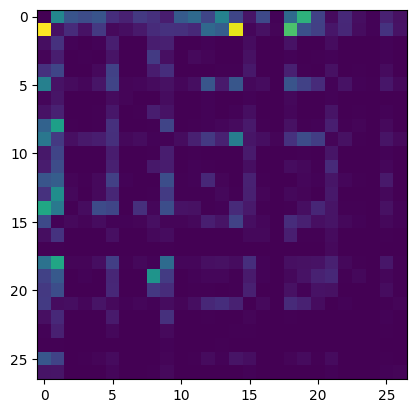

In [26]:
plt.imshow(N)

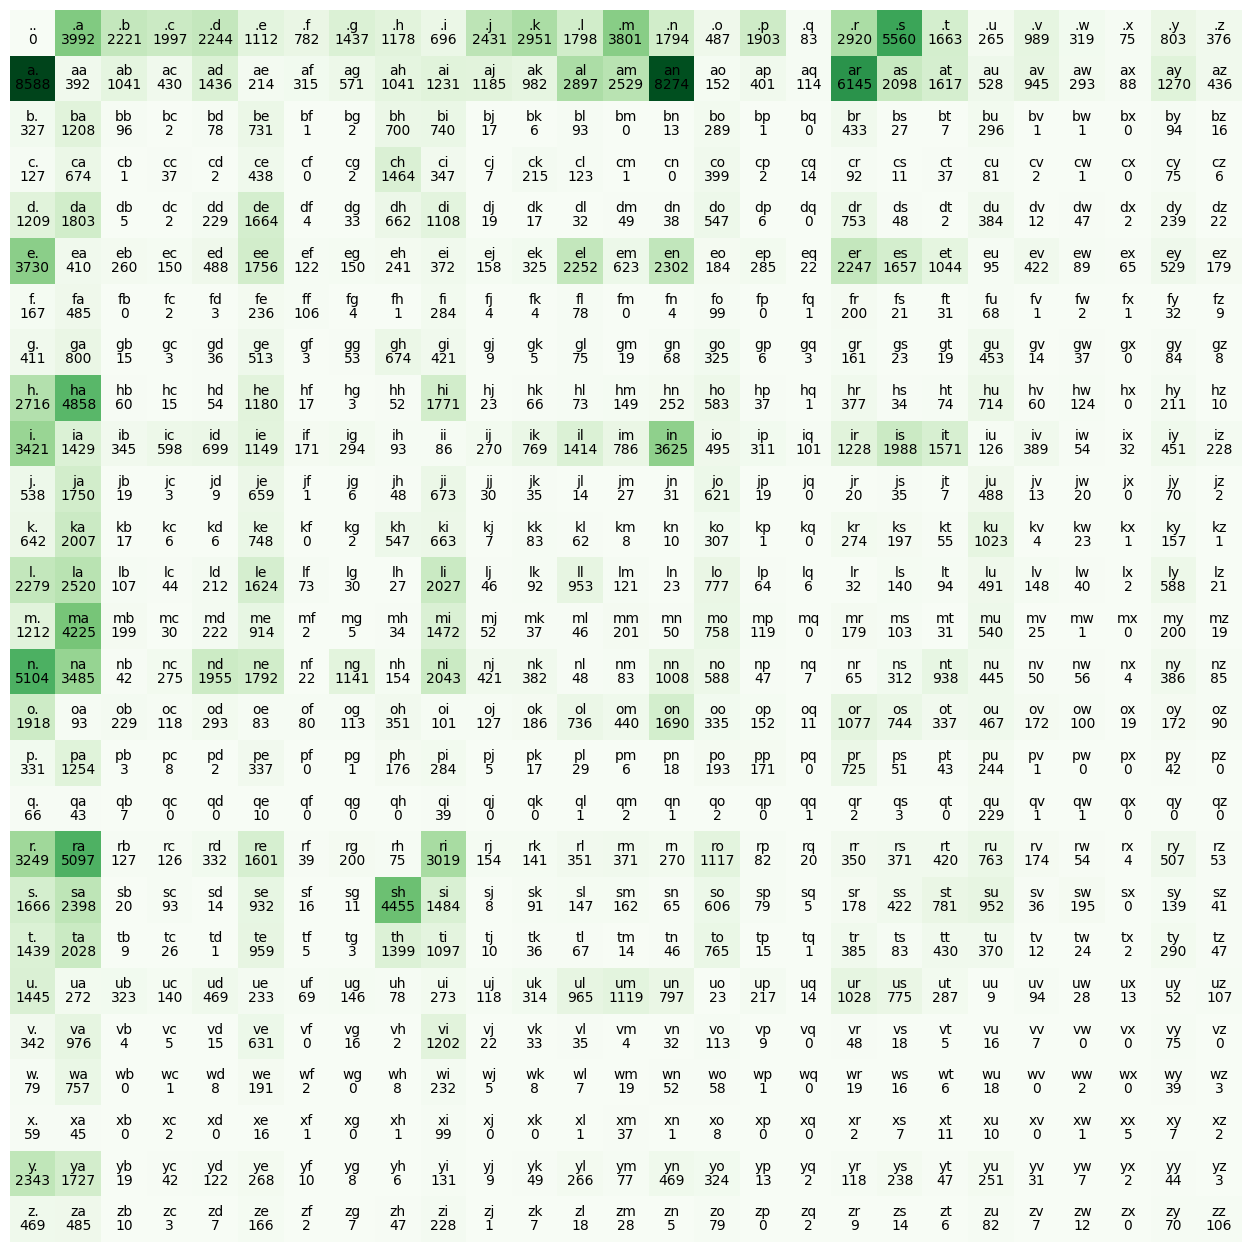

In [27]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap="Greens")
for i in range(27):
    for j in range(27):
        bigram = itoc[i] + itoc[j]
        plt.text(j, i, bigram, ha='center', va='bottom', color='black')
        plt.text(j, i, N[i, j].item(), ha='center', va='top', color='black')
plt.axis('off');

In [277]:
# sampling -> pick a random variable from the distribution according to the probabilities of the random variables
g = torch.Generator().manual_seed(SEED)     # reproducibility

In [281]:
test = torch.rand(3, generator=g)       # get 3 random variables b/w [0,1]
test

tensor([0.9593, 0.3904, 0.6009])

In [282]:
test.sum()

tensor(1.9506)

In [283]:
test = test/test.sum()          # calculate the probabilities of RV's -> value/total_value
test                            # 1st element has ~50% prob. i.e, if we sample the test n times, n/2 times 1st element should come, then 3rd and 2nd

tensor([0.4918, 0.2002, 0.3080])

In [295]:
# sampling from multiple variables using torch
torch.multinomial(test, num_samples=10, replacement=True, generator=g)

tensor([0, 0, 2, 2, 0, 2, 1, 1, 0, 0])

In [297]:
N[0]

tensor([   0, 3992, 2221, 1997, 2244, 1112,  782, 1437, 1178,  696, 2431, 2951,
        1798, 3801, 1794,  487, 1903,   83, 2920, 5560, 1663,  265,  989,  319,
          75,  803,  376], dtype=torch.int32)

In [298]:
N[0].float()

tensor([   0., 3992., 2221., 1997., 2244., 1112.,  782., 1437., 1178.,  696.,
        2431., 2951., 1798., 3801., 1794.,  487., 1903.,   83., 2920., 5560.,
        1663.,  265.,  989.,  319.,   75.,  803.,  376.])

In [302]:
p = N[0].float()
p = p/p.sum()
p

tensor([0.0000, 0.0910, 0.0506, 0.0455, 0.0511, 0.0253, 0.0178, 0.0328, 0.0268,
        0.0159, 0.0554, 0.0673, 0.0410, 0.0866, 0.0409, 0.0111, 0.0434, 0.0019,
        0.0665, 0.1267, 0.0379, 0.0060, 0.0225, 0.0073, 0.0017, 0.0183, 0.0086])

In [319]:
idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itoc[idx]

's'

In [324]:
# try creating a word
prev = ctoi['.']               # at the start, prev char will be '.' so idx will be 0
out = []
while True:
    p = N[prev].float()
    p = p/p.sum()
    pred = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itoc[pred])
    if pred==0: 
        break           # end if '.' is predicted -> end of word
    prev = pred
print(''.join(out))

linamo.


In [374]:
# try creating 10 words
g = torch.Generator().manual_seed(SEED)  

for _ in range(10):
    prev = ctoi['.']               # at the start, prev char will be '.' so idx will be 0
    out = []
    while True:
        p = N[prev].float()
        p = p/p.sum()
        pred = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itoc[pred])
        if pred==0: 
            break           # end if '.' is predicted -> end of word
        prev = pred
    print(''.join(out))

anuguenvi.
s.
mabidushantubun.
silayanarothah.
su.
le.
epichanden.
dizu.
k.
pomajordr.


In [375]:
# previous is fine because it'll be worse if we give same probability to each bigram
g = torch.Generator().manual_seed(SEED)  

for _ in range(10):
    prev = ctoi['.']               # at the start, prev char will be '.' so idx will be 0
    out = []
    while True:
        # p = N[prev].float()
        # p = p/p.sum()
        p = torch.ones(27)/27.0
        pred = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itoc[pred])
        if pred==0: 
            break           # end if '.' is predicted -> end of word
        prev = pred
    print(''.join(out))

xjugueovtps.
fabiquedxfmubnwmsflaypggzofmwhwlxoln.
epjccuodsgjdmzu.
xnxcmjjobdrggbdllk.
mnqhqyjfbhcvghigeaczalcvjwiajwtphjpdmqsotcc.
welqxosvgkocobr.
uklnncvrigmydysoumf.
pjjiewx.
lhmjuhm.
fsckbirdovhgn.


In [354]:
# efficiency -> instead of calculating probs each time, calculate once and lookup
# we have to calculate probabilities for each row -> each row's prob = each_element_in_row/sum_of_all_cols_of_this_row
P = N.float()

In [356]:
P.sum() # cannot use this as P/P.sum(), because it is the sum of entire matrix. instead we need row wise

tensor(306991.)

In [364]:
eg = torch.Tensor([[1,2,3],[4,5,6]])
eg.sum(dim=0)           # sums all rows for each column

tensor([5., 7., 9.])

In [365]:
eg.sum(dim=0, keepdim=True).shape

torch.Size([1, 3])

In [358]:
P.sum(dim=0) # sums all the rows and give one value per column

tensor([43877., 45213.,  5179.,  4158.,  8936., 20157.,  1843.,  4238., 13514.,
        22123.,  5138.,  6851., 12581., 10676., 20938., 10234.,  3941.,   408.,
        19067., 14996.,  9563.,  9408.,  3610.,  1531.,   315.,  6626.,  1870.])

In [361]:
P.sum(dim=0).shape

torch.Size([27])

In [359]:
P.sum(dim=0, keepdim=True)

tensor([[43877., 45213.,  5179.,  4158.,  8936., 20157.,  1843.,  4238., 13514.,
         22123.,  5138.,  6851., 12581., 10676., 20938., 10234.,  3941.,   408.,
         19067., 14996.,  9563.,  9408.,  3610.,  1531.,   315.,  6626.,  1870.]])

In [360]:
P.sum(dim=0, keepdim=True).shape        # one value per column

torch.Size([1, 27])

In [366]:
eg.sum(dim=1)       # sums all the columns(values) of each row

tensor([ 6., 15.])

In [367]:
eg.sum(dim=1, keepdim=True).shape

torch.Size([2, 1])

In [362]:
P.sum(dim=1, keepdim=True)          # this is what we want -> total of each row

tensor([[43877.],
        [45213.],
        [ 5179.],
        [ 4158.],
        [ 8936.],
        [20157.],
        [ 1843.],
        [ 4238.],
        [13514.],
        [22123.],
        [ 5138.],
        [ 6851.],
        [12581.],
        [10676.],
        [20938.],
        [10234.],
        [ 3941.],
        [  408.],
        [19067.],
        [14996.],
        [ 9563.],
        [ 9408.],
        [ 3610.],
        [ 1531.],
        [  315.],
        [ 6626.],
        [ 1870.]])

In [363]:
P.sum(dim=1, keepdim=True).shape

torch.Size([27, 1])

In [368]:
N[1].float()

tensor([8588.,  392., 1041.,  430., 1436.,  214.,  315.,  571., 1041., 1231.,
        1185.,  982., 2897., 2529., 8274.,  152.,  401.,  114., 6145., 2098.,
        1617.,  528.,  945.,  293.,   88., 1270.,  436.])

In [369]:
# to calculate element-wise, we broadcast in tensors, BROADCASTING is VERY IMP even in TRANSFORMERS etc
# broad casting rules - 
    # 1. align all shapes to the right
    # 2. start from right, each shape must be either equal, one can be empty, one can be 1

# for our example - 
    # 1. [27,27]
    #    [27, 1]
    # 2. since 1, this will copy value across all columns -> 27 same values (totals) for entire row eg, for 1st row - [43877., 43877., ......]
    # this will get divided, eg 0th row -> [0., 3992., 2221., 1997., ....] / [43877., 43877., 43877., 43877., ......] 
    #                        eg 1st row -> [8588.,  392., 1041.,  430., ...] / [45213., 45213., 45213., 45213., ....] which gives prob as we want

# CATCH - if we don't mention keepdim, then
    # 1. [27, 27]
    #        [27]
    # 2. since 0, this will copy value across all rows -> 27 same rows 
    # this will get divided, eg 0th row -> [0., 3992., 2221., 1997., ....] / [43877., 45213.,  5179.,  4158., ......] 
    #                        eg 1st row -> [8588.,  392., 1041.,  430., ...] / [43877., 45213.,  5179.,  4158., ......] <<< NOT WHAT WE WANT >>>
    
# CAREFUL WITH BROADCASTING -> will introduce bugs those are impossible to find
# RESPECT and LEARN BROADCASTING - https://pytorch.org/docs/stable/notes/broadcasting.html

In [24]:
P = N.float()
# P = P/P.sum(dim=1, keepdim=True)
P /= P.sum(dim=1, keepdim=True)             # use in-place when possible -> saves memory

In [377]:
# test if we calculated correctly -> each row's sum should be zero (sum of all probs = 1)
P[0].sum()

tensor(1.0000)

In [381]:
# if it's other way, we get probs along columns which is not what we want
wrong = N.float()
wrong = wrong/wrong.sum(dim=1)
print(wrong[0].sum(), wrong[:, 0].sum())

tensor(6.1768) tensor(1.)


In [376]:
# try creating 10 words
g = torch.Generator().manual_seed(SEED)   

for _ in range(10):
    prev = ctoi['.']               # at the start, prev char will be '.' so idx will be 0
    out = []
    while True:
        p = P[prev]
        pred = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itoc[pred])
        if pred==0: 
            break           # end if '.' is predicted -> end of word
        prev = pred
    print(''.join(out))

anuguenvi.
s.
mabidushantubun.
silayanarothah.
su.
le.
epichanden.
dizu.
k.
pomajordr.


In [382]:
# GOAL: maximize the likelihood of the data w.r.t model parameters (matrix of probs now, later can be weights) (statistical modelling)
# Likelihood -> product of all prediction probabilities     @ since prob is [0,1], this number will be veeeeery small
# Log Likelihood -> sum of all prediction probabilities     @ log(a*b)=log(a)+log(b) this is big number to deal with,ranges (-inf, 0] b/c log(1)=0
# -ve Log Likelihood -> loss should be "the lower, the better" so apply -ve to make it easier to optimize  @ lowest loss will be '0'

In [385]:
# calculate probs of each prediction(bigram) for 1st 2 names
for name in names[:2]:
    name = ['.'] + list(name) + ['.']
    for c1, c2 in zip(name, name[1:]):
        ix1, ix2 = ctoi[c1], ctoi[c2]
        prob = P[ix1, ix2]
        print(f"{c1}{c2}: {prob:.4f}")

.j: 0.0554
jo: 0.1209
od: 0.0286
de: 0.1862
en: 0.1142
ne: 0.0856
e.: 0.1850
.j: 0.0554
ja: 0.3406
ah: 0.0230
he: 0.0873
ed: 0.0242
d.: 0.1353


In [389]:
# calculate log likelihood of each prediction(bigram) for 1st 2 names
log_likelihood = 0.0            # sum of all log probs
n = 0
for name in names[:2]:
    name = ['.'] + list(name) + ['.']
    for c1, c2 in zip(name, name[1:]):
        n+=1
        ix1, ix2 = ctoi[c1], ctoi[c2]
        prob = P[ix1, ix2]
        log_prob = torch.log(prob)
        log_likelihood+=log_prob
        print(f"{c1}{c2}: {prob:.4f} {log_prob:.4f}")
print(f"{log_likelihood=}")
nll = -log_likelihood
print(f"{nll=}")
avg_nll = nll/n
print(f"{avg_nll=}")


.j: 0.0554 -2.8931
jo: 0.1209 -2.1131
od: 0.0286 -3.5533
de: 0.1862 -1.6809
en: 0.1142 -2.1698
ne: 0.0856 -2.4582
e.: 0.1850 -1.6871
.j: 0.0554 -2.8931
ja: 0.3406 -1.0770
ah: 0.0230 -3.7712
he: 0.0873 -2.4382
ed: 0.0242 -3.7210
d.: 0.1353 -2.0003
log_likelihood=tensor(-32.4563)
nll=tensor(32.4563)
avg_nll=tensor(2.4966)


In [390]:
# should get similar avg loss for entire dataset
log_likelihood = 0.0            # sum of all log probs
n = 0
for name in names:
    name = ['.'] + list(name) + ['.']
    for c1, c2 in zip(name, name[1:]):
        n+=1
        ix1, ix2 = ctoi[c1], ctoi[c2]
        prob = P[ix1, ix2]
        log_prob = torch.log(prob)
        log_likelihood+=log_prob
        # print(f"{c1}{c2}: {prob:.4f} {log_prob:.4f}")
print(f"{log_likelihood=}")
nll = -log_likelihood
print(f"{nll=}")
avg_nll = nll/n
print(f"{avg_nll=}")

log_likelihood=tensor(-768981.1875)
nll=tensor(768981.1875)
avg_nll=tensor(2.5049)


In [394]:
# try for some possible example
log_likelihood = 0.0            # sum of all log probs
n = 0
for name in ["hansith"]:
    name = ['.'] + list(name) + ['.']
    for c1, c2 in zip(name, name[1:]):
        n+=1
        ix1, ix2 = ctoi[c1], ctoi[c2]
        prob = P[ix1, ix2]
        log_prob = torch.log(prob)
        log_likelihood+=log_prob
        print(f"{c1}{c2}: {prob:.4f} {log_prob:.4f}")
print(f"{log_likelihood=}")
nll = -log_likelihood
print(f"{nll=}")
avg_nll = nll/n
print(f"{avg_nll=}")


.h: 0.0268 -3.6176
ha: 0.3595 -1.0231
an: 0.1830 -1.6983
ns: 0.0149 -4.2063
si: 0.0990 -2.3130
it: 0.0710 -2.6449
th: 0.1463 -1.9221
h.: 0.2010 -1.6046
log_likelihood=tensor(-19.0299)
nll=tensor(19.0299)
avg_nll=tensor(2.3787)


In [397]:
# try for some impossible example
log_likelihood = 0.0            # sum of all log probs
n = 0
for name in ["hansithx"]:
    name = ['.'] + list(name) + ['.']
    for c1, c2 in zip(name, name[1:]):
        n+=1
        ix1, ix2 = ctoi[c1], ctoi[c2]
        prob = P[ix1, ix2]
        log_prob = torch.log(prob)
        log_likelihood+=log_prob
        print(f"{c1}{c2}: {prob:.4f} {log_prob:.4f}")
print(f"{log_likelihood=}")
nll = -log_likelihood
print(f"{nll=}")
avg_nll = nll/n
print(f"{avg_nll=}")

.h: 0.0268 -3.6176
ha: 0.3595 -1.0231
an: 0.1830 -1.6983
ns: 0.0149 -4.2063
si: 0.0990 -2.3130
it: 0.0710 -2.6449
th: 0.1463 -1.9221
hx: 0.0000 -inf
x.: 0.1873 -1.6750
log_likelihood=tensor(-inf)
nll=tensor(inf)
avg_nll=tensor(inf)


In [399]:
# Since the probability of 'hx' is 0, log is -inf and total loss is inf.
# this is not desirable b/c it gives high spiked numbers to deal with making loss curve spiky
# MODEL SMOOTHING/REGULARIZE this to get smoother curve so that we can optimize efficiently.

# one way is we can assign a small fake count to each cell so that none of the combinations gives zero probability

In [28]:
# add 1(can be any +ve integer depending on how smooth you want) to all the available bigram counts

P = (N+1).float()            # 1 is broadcasted to all elements of the metrix
P /= P.sum(dim=1, keepdim=True)

# try for some impossible example
log_likelihood = 0.0            # sum of all log probs
n = 0
for name in ["hansithx"]:
    name = ['.'] + list(name) + ['.']
    for c1, c2 in zip(name, name[1:]):
        n+=1
        ix1, ix2 = ctoi[c1], ctoi[c2]
        prob = P[ix1, ix2]
        log_prob = torch.log(prob)
        log_likelihood+=log_prob
        print(f"{c1}{c2}: {prob:.4f} {log_prob:.4f}")
print(f"{log_likelihood=}")
nll = -log_likelihood
print(f"{nll=}")
avg_nll = nll/n
print(f"{avg_nll=}")

.h: 0.0269 -3.6173
ha: 0.3588 -1.0249
an: 0.1829 -1.6987
ns: 0.0149 -4.2044
si: 0.0988 -2.3142
it: 0.0710 -2.6455
th: 0.1460 -1.9242
hx: 0.0001 -9.5135
x.: 0.1754 -1.7405
log_likelihood=tensor(-28.6832)
nll=tensor(28.6832)
avg_nll=tensor(3.1870)


In [35]:
# test inference -
# give me 10 name starting with 'd'

num_words = 10
starting_with = 'd'
g = torch.Generator().manual_seed(SEED)   

for _ in range(num_words):
    prev = ctoi[starting_with]               # at the start, prev char will be '.' so idx will be 0
    out = []
    out.append(starting_with)
    while True:
        p = P[prev]
        pred = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itoc[pred])
        if pred==0: 
            break           # end if '.' is predicted -> end of word
        prev = pred
    print(''.join(out[:-1]))            # discard '.' at the end


danuguenvi
da
dar
didushantubun
dillayanarothah
de
d
dan
depichanden
deszu


In [ ]:
torch.save(P, "count_probs.pt")

In [ ]:
test_p = torch.load("count_probs.pt")

In [ ]:
# test inference -
# give me 10 name starting with 'd'

num_words = 10
starting_with = 'd'
g = torch.Generator().manual_seed(SEED)   

for _ in range(num_words):
    prev = ctoi[starting_with]               # at the start, prev char will be '.' so idx will be 0
    out = []
    out.append(starting_with)
    while True:
        p = test_p[prev]
        pred = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itoc[pred])
        if pred==0: 
            break           # end if '.' is predicted -> end of word
        prev = pred
    print(''.join(out[:-1]))            # discard '.' at the end


danuguenvi
da
dar
didushantubun
dillayanarothah
de
d
dan
depichanden
deszu
